In [1]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt 
from datetime import timedelta
%matplotlib inline

#from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score

import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [2]:
labels = pd.read_csv("fiuba-trocafone-tp2-final-set/labels_training_set.csv")
df = pd.read_csv("fiuba-trocafone-tp2-final-set/events_up_to_01062018.csv")

C:\Users\seba\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (3,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["month"] = df["timestamp"].dt.month
df["day"] = df["timestamp"].dt.day

In [7]:
df["event"].value_counts()

viewed product       1248124
brand listing         216312
visited site          204069
ad campaign hit       191388
generic listing       160176
searched products     130616
search engine hit     106406
checkout               65315
staticpage             11201
conversion              7091
lead                     983
Name: event, dtype: int64

### Dia, mes con mayor cantidad de visitas de cada persona

In [4]:
# Dia con mas entradas y su cantidad de entradas

entradas_x_dia = df.groupby("person")['day'].value_counts().rename("cant_dia_freq").reset_index()
entradas_x_dia.columns = ['person', 'day', 'cant_dia_freq']
entradas_x_dia = entradas_x_dia.sort_values('cant_dia_freq',ascending=False)
dia_mas_entradas = entradas_x_dia.drop_duplicates(subset=['person'])
dia_mas_entradas.head()

,person,day,cant_dia_freq
99325,c76b8417,3,652
28266,37eff05b,29,616
112559,e1443dd4,30,572
51164,656c18ef,10,512
41082,50e16a8a,19,423


In [5]:
# Mes con mas entradas y su cantidad de entradas

entradas_x_mes = df.groupby("person")['month'].value_counts().rename("cant_mes").reset_index()
entradas_x_mes.columns = ['person', 'month', 'cant_mes']
entradas_x_mes = entradas_x_mes.sort_values('cant_mes',ascending=False)
mes_mas_entradas = entradas_x_mes.drop_duplicates(subset=['person'])
mes_mas_entradas.head()

,person,month,cant_mes
38966,c76b8417,5,3028
18217,5c76e694,5,1609
32890,a7ffa917,5,1604
4824,18489dd5,5,1563
9989,33385551,4,1539


In [6]:
# Merge

cant_mes_mas_entradas = mes_mas_entradas[["person", "cant_mes"]]
cant_dia_mas_entradas = dia_mas_entradas[["person", "cant_dia_freq"]]

mes_dia_mas_entradas = pd.merge(cant_mes_mas_entradas, cant_dia_mas_entradas, on="person", how="inner")

df_con_labels = pd.merge(mes_dia_mas_entradas, labels, on="person", how="inner")
df_con_labels.head()

,person,cant_mes,cant_dia_freq,label
0,5c76e694,1609,191,0
1,18489dd5,1563,174,0
2,1775ba85,1450,126,0
3,6abd2bf1,1334,300,0
4,97b0c0d1,1328,217,0


In [7]:
df_con_labels_num = df_con_labels[["cant_mes", "cant_dia_freq", "label"]]

## Prueba

In [8]:
# Separamos la variable a predecir

X, y = df_con_labels_num.iloc[:,:-1],df_con_labels_num.iloc[:,-1]

In [9]:
# Convertimos los datos a DMatrix

data_dmatrix = xgb.DMatrix(data=X,label=y)


In [10]:

#Creamos set de entrenamiento y test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [11]:
#Instanciamos el regresor de XGBoost

ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

xg_reg = xgb.XGBRegressor(objective ='binary:hinge', 
                colsample_bytree = 0.8, learning_rate = 0.1,
                max_depth = 5, n_estimators = 6, scale_pos_weight = 1, min_child_weight=1)


In [12]:
#Entrenamos

xg_reg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=6,
       n_jobs=1, nthread=None, objective='binary:hinge', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [13]:
# Predecimos

preds = xg_reg.predict(X_test)

In [14]:
# Vemos que onda

train_accuracy = accuracy_score(y_train, xg_reg.predict(X_train))
test_accuracy = accuracy_score(y_test, preds)
matriz_de_confusion = confusion_matrix(y_test, preds)
area_debajo_de_curva = roc_auc_score(y_test, preds)

print("Train accuracy: ", train_accuracy)
print("Test acuracy: ", test_accuracy)
print("ROC auc score: ", area_debajo_de_curva)
print("Confusion matrix: ")
print(matriz_de_confusion)

Train accuracy:  0.9303328826218531
Test acuracy:  0.927890806077775
ROC auc score:  0.5285741205381574
Confusion matrix: 
[[3586   86]
 [ 194   17]]


### Entradas en los ultimos 30 dias (hasta la ultima visita)

In [15]:
df_meses = df[["timestamp", "person", "month"]]
df_ultimo_dia = df_meses.groupby("person")["timestamp"].max().reset_index()
df_ultimo_dia.columns = ["person", "last_day"]
df_meses_ultimo_dia = pd.merge(df_ultimo_dia, df_meses, on="person", how="inner")
entradas_30_dias = df_meses_ultimo_dia.loc[((df_meses_ultimo_dia["last_day"] - timedelta(days=30)) < \
                                           df_meses_ultimo_dia["timestamp"]) & (df_meses_ultimo_dia["timestamp"]< \
                                           df_meses_ultimo_dia["last_day"])]
entradas_30_dias.head()

,person,last_day,timestamp,month
1,0008ed71,2018-05-17 16:28:37,2018-05-17 12:27:47,5
2,0008ed71,2018-05-17 16:28:37,2018-05-17 13:45:00,5
3,0008ed71,2018-05-17 16:28:37,2018-05-17 16:22:06,5
4,0008ed71,2018-05-17 16:28:37,2018-05-17 13:44:59,5
5,0008ed71,2018-05-17 16:28:37,2018-05-17 16:21:54,5


In [16]:
entradas_30_dias_df = entradas_30_dias["person"].value_counts().rename("entradas_30_dias").reset_index()
entradas_30_dias_df.columns = ["person", "entradas_30_dias"]
entradas_30_dias_df.head()

,person,entradas_30_dias
0,c76b8417,3027
1,5c76e694,1608
2,a7ffa917,1603
3,18489dd5,1562
4,622b4acf,1458


In [17]:
# Merge

df_con_labels2 = pd.merge(entradas_30_dias_df, df_con_labels, on="person", how="inner")
df_con_labels2.head()

,person,entradas_30_dias,cant_mes,cant_dia_freq,label
0,5c76e694,1608,1609,191,0
1,18489dd5,1562,1563,174,0
2,6abd2bf1,1319,1334,300,0
3,97b0c0d1,1306,1328,217,0
4,595b9b50,1177,1179,377,0


In [18]:
df_con_labels2_num = df_con_labels2[["entradas_30_dias", "cant_mes", "cant_dia_freq", "label"]]

## Prueba

In [19]:
# Separamos la variable a predecir

X, y = df_con_labels2_num.iloc[:,:-1], df_con_labels2_num.iloc[:,-1]

In [20]:
# Convertimos los datos a DMatrix

data_dmatrix = xgb.DMatrix(data=X,label=y)


In [21]:

#Creamos set de entrenamiento y test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [22]:
#Instanciamos el regresor de XGBoost

ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

xg_reg = xgb.XGBRegressor(objective ='binary:hinge', 
                colsample_bytree = 0.8, learning_rate = 0.1,
                max_depth = 5, n_estimators = 6, scale_pos_weight = 1, min_child_weight=1)


In [23]:
#Entrenamos

xg_reg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=6,
       n_jobs=1, nthread=None, objective='binary:hinge', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [24]:
# Predecimos

preds = xg_reg.predict(X_test)

array([0., 0., 0., ..., 0., 1., 0.], dtype=float32)

In [25]:
# Vemos que onda

train_accuracy = accuracy_score(y_train, xg_reg.predict(X_train))
test_accuracy = accuracy_score(y_test, preds)
matriz_de_confusion = confusion_matrix(y_test, preds)
area_debajo_de_curva = roc_auc_score(y_test, preds)

print("Train accuracy: ", train_accuracy)
print("Test acuracy: ", test_accuracy)
print("ROC auc score: ", area_debajo_de_curva)
print("Confusion matrix: ")
print(matriz_de_confusion)

Train accuracy:  0.8935051275308966
Test acuracy:  0.8821982645280042
ROC auc score:  0.5636387599747587
Confusion matrix: 
[[3312  282]
 [ 166   43]]


## Entradas en el ultimo mes (mes 5)

In [26]:
entradas_mes_5 = df_meses.loc[df_meses["month"] == 5]
cant_entradas_mes_5 = entradas_mes_5.groupby("person").agg({"month": "count"}).reset_index()
cant_entradas_mes_5.columns = ["person", "cant_mes_5"]
cant_entradas_mes_5.head()

,person,cant_mes_5
0,0008ed71,6
1,00091926,448
2,000ba417,206
3,000c79fe,17
4,000e4d9e,411


In [27]:
# Merge

df_con_mes_5 = pd.merge(cant_entradas_mes_5, df_con_labels2, on="person", how="inner")
df_con_mes_5.head()

,person,cant_mes_5,entradas_30_dias,cant_mes,cant_dia_freq,label
0,0008ed71,6,5,6,6,0
1,000c79fe,17,16,17,17,0
2,001802e4,19,18,19,19,0
3,0019e639,290,358,290,72,0
4,001b0bf9,7,6,7,7,0


## Cantidad de entradas totales

In [28]:
entradas_tot = df.groupby("person").agg({"person": "count"})
#cant_entradas_tot = entradas_tot[["person", "entradas_tot"]]
entradas_tot.columns = ["cant_entradas"]
entradas_tot.reset_index(inplace=True)
entradas_tot.head()

,person,cant_entradas
0,0008ed71,6
1,00091926,448
2,00091a7a,10
3,000ba417,206
4,000c79fe,17


In [29]:
# Merge

df_con_entradas = pd.merge(entradas_tot, df_con_mes_5, on="person", how="inner")
df_con_entradas.head()

,person,cant_entradas,cant_mes_5,entradas_30_dias,cant_mes,cant_dia_freq,label
0,0008ed71,6,6,5,6,6,0
1,000c79fe,17,17,16,17,17,0
2,001802e4,19,19,18,19,19,0
3,0019e639,471,290,358,290,72,0
4,001b0bf9,7,7,6,7,7,0


### Cantidad de checkouts

In [30]:
checkouts = df.loc[df["event"] == "checkout"]
checkouts_tot = checkouts.groupby("person")["event"].value_counts().rename("check_tot").reset_index()
cant_checkouts_tot = checkouts_tot[["person", "check_tot"]]

In [31]:
# Merge

df_con_check = pd.merge(cant_checkouts_tot, df_con_entradas, on="person", how="inner")
df_con_check.head()

,person,check_tot,cant_entradas,cant_mes_5,entradas_30_dias,cant_mes,cant_dia_freq,label
0,0008ed71,3,6,6,5,6,6,0
1,000c79fe,1,17,17,16,17,17,0
2,001802e4,1,19,19,18,19,19,0
3,0019e639,15,471,290,358,290,72,0
4,001b0bf9,2,7,7,6,7,7,0


In [32]:
# xgboost solo usa valores numericos
df_con_check_num = df_con_check.drop(columns="person")

### Prueba

In [33]:
# Separamos la variable a predecir

X, y = df_con_check_num.iloc[:,:-1], df_con_check_num.iloc[:,-1]

In [34]:
# Convertimos los datos a DMatrix

data_dmatrix = xgb.DMatrix(data=X,label=y)


In [35]:

#Creamos set de entrenamiento y test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [36]:
#Instanciamos el regresor de XGBoost

ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

xg_reg = xgb.XGBRegressor(objective ='binary:hinge', 
                colsample_bytree = 0.8, learning_rate = 0.1,
                max_depth = 5, n_estimators = 6, scale_pos_weight = 1, min_child_weight=1)


In [37]:
#Entrenamos

xg_reg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=6,
       n_jobs=1, nthread=None, objective='binary:hinge', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [38]:
# Predecimos

preds = xg_reg.predict(X_test)

In [39]:
# Vemos que onda

train_accuracy = accuracy_score(y_train, xg_reg.predict(X_train))
test_accuracy = accuracy_score(y_test, preds)
matriz_de_confusion = confusion_matrix(y_test, preds)
area_debajo_de_curva = roc_auc_score(y_test, preds)

print("Train accuracy: ", train_accuracy)
print("Test acuracy: ", test_accuracy)
print("ROC auc score: ", area_debajo_de_curva)
print("Confusion matrix: ")
print(matriz_de_confusion)

Train accuracy:  0.9448868071818891
Test acuracy:  0.9375585388698096
ROC auc score:  0.5753296607423287
Confusion matrix: 
[[2988  138]
 [  62   15]]


## Cantidad de entradas al evento mas visitado por cada persona

In [40]:
s = df.groupby("person")['event'].value_counts().rename().reset_index()
s.columns = ['person', 'event', 'cant_ev']
s = s.sort_values('cant_ev',ascending=False)
mayor_evento = s.drop_duplicates(subset=['person']).drop(columns="event")
mayor_evento.head()

,person,cant_ev
97161,6abd2bf1,2355
160896,b1f4dbf6,2233
129961,8fb4929e,1912
141831,9ccf882a,1891
6202,06ed04d6,1881


In [41]:
# Cantidad de entradas al modelo mas visitado por cada persona

mod = df.groupby("person")['model'].value_counts().rename().reset_index()
mod.columns = ['person', 'model', 'cant_mod']
mod = mod.sort_values('cant_mod',ascending=False)
mayor_modelo = mod.drop_duplicates(subset=['person']).drop(columns="model")
mayor_modelo.head()

,person,cant_mod
154136,b1f4dbf6,836
20443,171e75cb,683
97765,6f19cfd9,624
94322,6abd2bf1,607
135679,9bf968c5,568


In [42]:
# Cantidad de entradas al search engine mas visitado por cada persona

eng = df.groupby("person")['search_engine'].value_counts().rename().reset_index()
eng.columns = ['person', 'search_engine', 'cant_eng']
eng = eng.sort_values('cant_eng',ascending=False)
mayor_engine = eng.drop_duplicates(subset=['person']).drop(columns="search_engine")
mayor_engine.head()

,person,cant_eng
20377,c76b8417,762
11210,6ca3126e,245
10145,622b4acf,206
3906,25b77cf2,161
9593,5c76e694,136


In [43]:
# Cantidad de entradas al campaign source mas visitado por cada persona

src = df.groupby("person")['campaign_source'].value_counts().rename().reset_index()
src.columns = ['person', 'campaign_source', 'cant_src']
src = src.sort_values('cant_src',ascending=False)
mayor_camp = src.drop_duplicates(subset=['person']).drop(columns="campaign_source")
mayor_camp.head()

,person,cant_src
529,02f14240,500
36357,c76b8417,374
19910,6ca3126e,335
17899,622b4acf,282
10671,3b2d17f6,221


In [44]:
# Cantidad de entradas desde la ciudad mas frecuente de cada persona

cty = df.groupby("person")['city'].value_counts().rename().reset_index()
cty.columns = ['person', 'city', 'cant_city']
src = cty.sort_values('cant_city',ascending=False)
mayor_ciudad = src.drop_duplicates(subset=['person']).drop(columns="city")
mayor_ciudad.head()

,person,cant_city
18380,5059f7fd,268
27926,7ac0c607,208
23603,67bdc946,207
58123,ffee0f18,173
35216,9b3b43aa,171


In [45]:
# Merge

from functools import reduce

# merge de todos los dfs

dfs = [mayor_ciudad, mayor_camp, mayor_engine, mayor_modelo, mayor_evento, df_con_check]
df_final = reduce(lambda left,right: pd.merge(left,right,on='person', how='inner'), dfs)
df_final.head()

,person,cant_city,cant_src,cant_eng,cant_mod,cant_ev,check_tot,cant_entradas,cant_mes_5,entradas_30_dias,cant_mes,cant_dia_freq,label
0,ffee0f18,173,76,65,80,1518,2,3458,218,217,1028,282,0
1,9b3b43aa,171,17,4,468,1289,7,1663,246,234,923,174,0
2,02f14240,155,500,6,272,523,13,1798,225,282,847,114,0
3,345fc18e,153,155,10,106,844,9,1569,367,364,1007,137,0
4,30ec9daf,152,30,10,83,423,5,803,185,184,189,68,0


In [46]:
df_final_num = df_final.drop(columns="person")

### Prueba

In [47]:
# Separamos la variable a predecir

X, y = df_final_num.iloc[:,:-1], df_final_num.iloc[:,-1]

# Convertimos los datos a DMatrix

data_dmatrix = xgb.DMatrix(data=X,label=y)

#Creamos set de entrenamiento y test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [48]:
#Instanciamos el regresor de XGBoost

ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

xg_reg = xgb.XGBRegressor(objective ='binary:hinge', 
                colsample_bytree = 0.8, learning_rate = 0.1,
                max_depth = 5, n_estimators = 6, scale_pos_weight = 1, min_child_weight=1)


In [49]:
#Entrenamos

xg_reg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=6,
       n_jobs=1, nthread=None, objective='binary:hinge', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [50]:
# Predecimos

preds = xg_reg.predict(X_test)

In [51]:
# Vemos que onda

train_accuracy = accuracy_score(y_train, xg_reg.predict(X_train))
test_accuracy = accuracy_score(y_test, preds)
matriz_de_confusion = confusion_matrix(y_test, preds)
area_debajo_de_curva = roc_auc_score(y_test, preds)

print("Train accuracy: ", train_accuracy)
print("Test acuracy: ", test_accuracy)
print("ROC auc score: ", area_debajo_de_curva)
print("Confusion matrix: ")
print(matriz_de_confusion)

Train accuracy:  0.9268054197513619
Test acuracy:  0.9167597765363128
ROC auc score:  0.5237218284622123
Confusion matrix: 
[[1635   97]
 [  52    6]]


## Distancia entre primer y ultimo dia de entrada al sitio

In [52]:
timestamp_df = df[["person", "timestamp"]]
ultimo_dia = timestamp_df.groupby("person")["timestamp"].max().rename("ultimo").reset_index()
primer_dia = timestamp_df.groupby("person")["timestamp"].min().rename("primer").reset_index()
distancia_dias = pd.merge(primer_dia, ultimo_dia, on="person", how="inner")
distancia_dias["distan_dias"] = (distancia_dias["ultimo"] - distancia_dias["primer"]).dt.days
distancia_dias = distancia_dias[["person", "distan_dias"]]
distancia_dias.head()

,person,distan_dias
0,0008ed71,0
1,00091926,27
2,00091a7a,0
3,000ba417,9
4,000c79fe,0


In [53]:
# Merge

df_con_distancias = pd.merge(distancia_dias, df_final, on="person", how="inner") 
df_con_distancias_num = df_con_distancias.drop(columns="person")
df_con_distancias_num.head()

,distan_dias,cant_city,cant_src,cant_eng,cant_mod,cant_ev,check_tot,cant_entradas,cant_mes_5,entradas_30_dias,cant_mes,cant_dia_freq,label
0,0,1,1,1,4,9,1,17,17,16,17,17,0
1,114,12,17,12,63,189,15,471,290,358,290,72,0
2,79,8,4,6,20,52,1,96,54,64,54,17,0
3,67,5,10,10,8,17,3,54,5,26,46,22,0
4,62,2,2,1,3,17,1,38,26,25,26,26,0


### Prueba

In [54]:
# Separamos la variable a predecir

X, y = df_con_distancias_num.iloc[:,:-1], df_con_distancias_num.iloc[:,-1]

# Convertimos los datos a DMatrix

data_dmatrix = xgb.DMatrix(data=X,label=y)

#Creamos set de entrenamiento y test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [55]:
#Instanciamos el regresor de XGBoost

ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

xg_reg = xgb.XGBRegressor(objective ='binary:hinge', 
                colsample_bytree = 0.8, learning_rate = 0.1,
                max_depth = 5, n_estimators = 6, scale_pos_weight = 1, min_child_weight=1)


In [56]:
#Entrenamos

xg_reg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=6,
       n_jobs=1, nthread=None, objective='binary:hinge', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [57]:
# Predecimos

preds = xg_reg.predict(X_test)

In [58]:
# Vemos que onda

train_accuracy = accuracy_score(y_train, xg_reg.predict(X_train))
test_accuracy = accuracy_score(y_test, preds)
matriz_de_confusion = confusion_matrix(y_test, preds)
area_debajo_de_curva = roc_auc_score(y_test, preds)

print("Train accuracy: ", train_accuracy)
print("Test acuracy: ", test_accuracy)
print("ROC auc score: ", area_debajo_de_curva)
print("Confusion matrix: ")
print(matriz_de_confusion)

Train accuracy:  0.9115798295851376
Test acuracy:  0.9067039106145252
ROC auc score:  0.59551431955538
Confusion matrix: 
[[1608  125]
 [  42   15]]


## Cantidad de modelos distintos vistos por cada usuario

In [59]:
modelos_df = df[["person", "model"]]
cant_modelos = modelos_df.groupby("person")["model"].nunique().rename("modelos_dist").reset_index()
cant_modelos.head()

,person,modelos_dist
0,0008ed71,3
1,00091926,36
2,00091a7a,3
3,000ba417,26
4,000c79fe,1


In [60]:
# Merge 

df_con_modelos = pd.merge(cant_modelos, df_con_distancias, on="person", how="inner")
df_con_modelos_num = df_con_modelos.drop(columns="person")
df_con_modelos_num.head()

,modelos_dist,distan_dias,cant_city,cant_src,cant_eng,cant_mod,cant_ev,check_tot,cant_entradas,cant_mes_5,entradas_30_dias,cant_mes,cant_dia_freq,label
0,1,0,1,1,1,4,9,1,17,17,16,17,17,0
1,26,114,12,17,12,63,189,15,471,290,358,290,72,0
2,6,79,8,4,6,20,52,1,96,54,64,54,17,0
3,6,67,5,10,10,8,17,3,54,5,26,46,22,0
4,9,62,2,2,1,3,17,1,38,26,25,26,26,0


### Prueba

In [61]:
# Separamos la variable a predecir

X, y = df_con_modelos_num.iloc[:,:-1], df_con_modelos_num.iloc[:,-1]

# Convertimos los datos a DMatrix

data_dmatrix = xgb.DMatrix(data=X,label=y)

#Creamos set de entrenamiento y test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [62]:
#Instanciamos el regresor de XGBoost

ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

xg_reg = xgb.XGBRegressor(objective ='binary:hinge', 
                colsample_bytree = 0.8, learning_rate = 0.1,
                max_depth = 5, n_estimators = 6, scale_pos_weight = 1, min_child_weight=1)


In [63]:
#Entrenamos

xg_reg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=6,
       n_jobs=1, nthread=None, objective='binary:hinge', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [64]:
# Predecimos

preds = xg_reg.predict(X_test)

In [65]:
# Vemos que onda

train_accuracy = accuracy_score(y_train, xg_reg.predict(X_train))
test_accuracy = accuracy_score(y_test, preds)
matriz_de_confusion = confusion_matrix(y_test, preds)
area_debajo_de_curva = roc_auc_score(y_test, preds)

print("Train accuracy: ", train_accuracy)
print("Test acuracy: ", test_accuracy)
print("ROC auc score: ", area_debajo_de_curva)
print("Confusion matrix: ")
print(matriz_de_confusion)

Train accuracy:  0.8923033943288169
Test acuracy:  0.8759776536312849
ROC auc score:  0.5881292961196991
Confusion matrix: 
[[1552  181]
 [  41   16]]


## Cantidad de días distintos de entrada al sitio

In [66]:
df_dias = df[["person", "timestamp"]]
df_dias["day_of_year"] = df_dias["timestamp"].dt.dayofyear
cant_dias_dist = df_dias.groupby("person")["day_of_year"].nunique().rename("cant_dias_dist").reset_index()
cant_dias_dist.head()

C:\Users\seba\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,person,cant_dias_dist
0,0008ed71,1
1,00091926,22
2,00091a7a,1
3,000ba417,3
4,000c79fe,1


In [67]:
# Merge 

df_con_dias_dist = pd.merge(cant_dias_dist, df_con_modelos, on="person", how="inner")
df_con_dias_dist_num = df_con_dias_dist.drop(columns=["person", "modelos_dist"])
df_con_dias_dist_num.head()

,cant_dias_dist,distan_dias,cant_city,cant_src,cant_eng,cant_mod,cant_ev,check_tot,cant_entradas,cant_mes_5,entradas_30_dias,cant_mes,cant_dia_freq,label
0,1,0,1,1,1,4,9,1,17,17,16,17,17,0
1,14,114,12,17,12,63,189,15,471,290,358,290,72,0
2,11,79,8,4,6,20,52,1,96,54,64,54,17,0
3,6,67,5,10,10,8,17,3,54,5,26,46,22,0
4,2,62,2,2,1,3,17,1,38,26,25,26,26,0


### Prueba

In [68]:
# Separamos la variable a predecir

X, y = df_con_dias_dist_num.iloc[:,:-1], df_con_dias_dist_num.iloc[:,-1]

# Convertimos los datos a DMatrix

data_dmatrix = xgb.DMatrix(data=X,label=y)

#Creamos set de entrenamiento y test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [69]:
#Instanciamos el regresor de XGBoost

ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

xg_reg = xgb.XGBRegressor(objective ='binary:hinge', 
                colsample_bytree = 0.8, learning_rate = 0.1,
                max_depth = 5, n_estimators = 6, scale_pos_weight = 1, min_child_weight=1)


In [70]:
#Entrenamos

xg_reg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=6,
       n_jobs=1, nthread=None, objective='binary:hinge', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [71]:
# Predecimos

preds = xg_reg.predict(X_test)

In [72]:
# Vemos que onda

train_accuracy = accuracy_score(y_train, xg_reg.predict(X_train))
test_accuracy = accuracy_score(y_test, preds)
matriz_de_confusion = confusion_matrix(y_test, preds)
area_debajo_de_curva = roc_auc_score(y_test, preds)

print("Train accuracy: ", train_accuracy)
print("Test acuracy: ", test_accuracy)
print("ROC auc score: ", area_debajo_de_curva)
print("Confusion matrix: ")
print(matriz_de_confusion)

Train accuracy:  0.8868557061042045
Test acuracy:  0.8698324022346369
ROC auc score:  0.6104058472783227
Confusion matrix: 
[[1538  195]
 [  38   19]]


## Promedio de entradas por dia

In [73]:
entradas_tot = df.groupby("person").agg({"person": "count"})
#cant_entradas_tot = entradas_tot[["person", "entradas_tot"]]
entradas_tot.columns = ["cant_entradas"]
entradas_tot.reset_index(inplace=True)

df_dias = df[["person", "timestamp"]]
df_dias["day_of_year"] = df_dias["timestamp"].dt.dayofyear
cant_dias_dist = df_dias.groupby("person")["day_of_year"].nunique().rename("cant_dias_dist").reset_index()

entradas_tot_y_dias = pd.merge(entradas_tot, cant_dias_dist, on="person", how="inner")
entradas_tot_y_dias["promedio_por_dia"] = (entradas_tot_y_dias["cant_dias_dist"] / entradas_tot_y_dias["cant_entradas"])
entradas_tot_y_dias.head()

C:\Users\seba\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,person,cant_entradas,cant_dias_dist,promedio_por_dia
0,0008ed71,6,1,0.166667
1,00091926,448,22,0.049107
2,00091a7a,10,1,0.100000
3,000ba417,206,3,0.014563
4,000c79fe,17,1,0.058824


In [74]:
entradas_tot_y_dias = entradas_tot_y_dias[["person", "promedio_por_dia"]]

## Promedio de entradas por mes

In [75]:
df_mes = df[["person", "month"]]
cant_meses_dist = df_mes.groupby("person")["month"].nunique().rename("cant_meses_dist").reset_index()

entradas_tot_y_meses = pd.merge(entradas_tot, cant_meses_dist, on="person", how="inner")
entradas_tot_y_meses["promedio_por_mes"] = (entradas_tot_y_meses["cant_meses_dist"] / entradas_tot_y_meses["cant_entradas"])
entradas_tot_y_meses = entradas_tot_y_meses[["person", "promedio_por_mes"]]

entradas_tot_y_meses.head()

,person,promedio_por_mes
0,0008ed71,0.166667
1,00091926,0.002232
2,00091a7a,0.100000
3,000ba417,0.004854
4,000c79fe,0.058824


In [76]:
# Merge

labels_con_promedios = pd.merge(entradas_tot_y_meses, entradas_tot_y_dias, on="person", how="inner")
labels_con_promedios = pd.merge(labels_con_promedios, df_con_dias_dist, on="person", how="inner")
labels_con_promedios_num = labels_con_promedios.drop(columns="person")
labels_con_promedios_num.head()

,promedio_por_mes,promedio_por_dia,cant_dias_dist,modelos_dist,distan_dias,cant_city,cant_src,cant_eng,cant_mod,cant_ev,check_tot,cant_entradas,cant_mes_5,entradas_30_dias,cant_mes,cant_dia_freq,label
0,0.058824,0.058824,1,1,0,1,1,1,4,9,1,17,17,16,17,17,0
1,0.008493,0.029724,14,26,114,12,17,12,63,189,15,471,290,358,290,72,0
2,0.031250,0.114583,11,6,79,8,4,6,20,52,1,96,54,64,54,17,0
3,0.055556,0.111111,6,6,67,5,10,10,8,17,3,54,5,26,46,22,0
4,0.052632,0.052632,2,9,62,2,2,1,3,17,1,38,26,25,26,26,0


### Prueba

In [77]:
# Separamos la variable a predecir

X, y = labels_con_promedios_num.iloc[:,:-1], labels_con_promedios_num.iloc[:,-1]

# Convertimos los datos a DMatrix

data_dmatrix = xgb.DMatrix(data=X,label=y, weight={1: 1, 0: 0.1})

#Creamos set de entrenamiento y test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [78]:
#Instanciamos el regresor de XGBoost

ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

xg_reg = xgb.XGBRegressor(objective ='binary:hinge', 
                colsample_bytree = 0.8, learning_rate = 0.1,
                max_depth = 5, n_estimators = 6, eval_metric = "auc", min_child_weight=1000)


In [79]:
#Entrenamos

xg_reg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eval_metric='auc', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=1000, missing=None,
       n_estimators=6, n_jobs=1, nthread=None, objective='binary:hinge',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [80]:
# Predecimos

preds = xg_reg.predict(X_test)

In [81]:
# Vemos 
train_accuracy = accuracy_score(y_train, xg_reg.predict(X_train))
test_accuracy = accuracy_score(y_test, preds)
matriz_de_confusion = confusion_matrix(y_test, preds)
area_debajo_de_curva = roc_auc_score(y_test, preds)

print("Train accuracy: ", train_accuracy)
print("Test acuracy: ", test_accuracy)
print("ROC auc score: ", area_debajo_de_curva)
print("Confusion matrix: ")
print(matriz_de_confusion)

Train accuracy:  0.8378265120826931
Test acuracy:  0.840782122905028
ROC auc score:  0.6463034389204402
Confusion matrix: 
[[1480  253]
 [  32   25]]


## Cantidad de eventos particulares

In [82]:
df_events = df[["person", "event"]]
cant_por_evento = pd.concat([pd.get_dummies(df_events['event']),df_events[['person']]],axis = 1).groupby('person')\
    .sum().reset_index()
cant_por_evento_short = cant_por_evento[["person", "ad campaign hit", "brand listing", "search engine hit", "searched products"]]

# Merge

labels_con_eventos = pd.merge(cant_por_evento_short, labels_con_promedios, on="person", how="inner")
labels_con_eventos_num = labels_con_eventos.drop(columns="person")
labels_con_eventos_num.head()

,ad campaign hit,brand listing,search engine hit,searched products,promedio_por_mes,promedio_por_dia,cant_dias_dist,modelos_dist,distan_dias,cant_city,...,cant_eng,cant_mod,cant_ev,check_tot,cant_entradas,cant_mes_5,entradas_30_dias,cant_mes,cant_dia_freq,label
0,1.0,0.0,1.0,9.0,0.058824,0.058824,1,1,0,1,...,1,4,9,1,17,17,16,17,17,0
1,29.0,165.0,13.0,11.0,0.008493,0.029724,14,26,114,12,...,12,63,189,15,471,290,358,290,72,0
2,7.0,7.0,6.0,0.0,0.031250,0.114583,11,6,79,8,...,6,20,52,1,96,54,64,54,17,0
3,13.0,4.0,10.0,0.0,0.055556,0.111111,6,6,67,5,...,10,8,17,3,54,5,26,46,22,0
4,2.0,17.0,1.0,0.0,0.052632,0.052632,2,9,62,2,...,1,3,17,1,38,26,25,26,26,0


### Prueba

In [83]:
# Separamos la variable a predecir

X, y = labels_con_eventos_num.iloc[:,:-1], labels_con_eventos_num.iloc[:,-1]

# Convertimos los datos a DMatrix

data_dmatrix = xgb.DMatrix(data=X,label=y, weight={1: 1, 0: 0.1})

#Creamos set de entrenamiento y test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [84]:
#Instanciamos el regresor de XGBoost

ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

xg_reg = xgb.XGBRegressor(objective ='binary:hinge', 
                colsample_bytree = 0.8, learning_rate = 0.1,
                max_depth = 5, n_estimators = 6, eval_metric = "auc", min_child_weight=1000)


In [85]:
#Entrenamos

xg_reg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eval_metric='auc', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=1000, missing=None,
       n_estimators=6, n_jobs=1, nthread=None, objective='binary:hinge',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [86]:
# Predecimos

preds = xg_reg.predict(X_test)

In [87]:
# Vemos 
train_accuracy = accuracy_score(y_train, xg_reg.predict(X_train))
test_accuracy = accuracy_score(y_test, preds)
matriz_de_confusion = confusion_matrix(y_test, preds)
area_debajo_de_curva = roc_auc_score(y_test, preds)

print("Train accuracy: ", train_accuracy)
print("Test acuracy: ", test_accuracy)
print("ROC auc score: ", area_debajo_de_curva)
print("Confusion matrix: ")
print(matriz_de_confusion)

Train accuracy:  0.853890208129627
Test acuracy:  0.8581005586592179
ROC auc score:  0.6467640538160173
Confusion matrix: 
[[1512  221]
 [  33   24]]


## Visitas a productos segun condicion, color y almacenamiento de producto.¶
copiado de santi

In [88]:
df_events_visitas_prod = df.loc[df['event'] == 'viewed product']
df_events_visitas_prod = df_events_visitas_prod[['person','storage','color','condition']]

df_events_visitas_prod_condition_storage = pd.concat([df_events_visitas_prod['person'],\
           pd.get_dummies(df_events_visitas_prod['storage']),\
           pd.get_dummies(df_events_visitas_prod['condition'])],axis = 1).groupby('person').sum().reset_index()

In [89]:
top_10_colores = df_events_visitas_prod['color'].value_counts().head(10).index


df_events_visitas_prod_color = df_events_visitas_prod.loc[df_events_visitas_prod['color'].isin(top_10_colores)]
df_events_visitas_prod_color = pd.concat([df_events_visitas_prod_color['person'],\
                                          pd.get_dummies(df_events_visitas_prod_color['color'])],axis = 1)

df_events_visitas_prod_color = df_events_visitas_prod_color.groupby('person').sum().reset_index()

df_events_visitas_prod_color_storage_condition = pd.merge(df_events_visitas_prod_condition_storage,\
                        df_events_visitas_prod_color, on = 'person', how = 'inner')

df_events_visitas_prod_color_storage_condition.head()

,person,128GB,16GB,256GB,32GB,4GB,512MB,64GB,8GB,Bom,...,Azul,Branco,Cinza espacial,Dourado,Ouro Rosa,Prata,Prateado,Preto,Preto Matte,Rosa
0,00091926,48.0,104.0,10.0,132.0,0.0,0.0,78.0,0.0,102.0,...,3.0,3.0,65.0,101.0,28.0,1.0,43.0,79.0,29.0,3.0
1,00091a7a,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,000ba417,0.0,108.0,1.0,20.0,1.0,0.0,1.0,22.0,110.0,...,4.0,15.0,1.0,14.0,0.0,0.0,0.0,71.0,0.0,7.0
3,000c79fe,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
4,000e4d9e,1.0,108.0,1.0,208.0,0.0,0.0,21.0,0.0,124.0,...,23.0,85.0,14.0,46.0,2.0,6.0,1.0,149.0,0.0,9.0


In [90]:
# Merge

labels_con_storage_color = pd.merge(df_events_visitas_prod_color_storage_condition, labels_con_eventos, on="person", how="inner")
labels_con_storage_color_num = labels_con_storage_color.drop(columns="person")
labels_con_storage_color_num.head()

,128GB,16GB,256GB,32GB,4GB,512MB,64GB,8GB,Bom,Bom - Sem Touch ID,...,cant_eng,cant_mod,cant_ev,check_tot,cant_entradas,cant_mes_5,entradas_30_dias,cant_mes,cant_dia_freq,label
0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,1,4,9,1,17,17,16,17,17,0
1,0.0,94.0,0.0,14.0,0.0,0.0,0.0,81.0,105.0,0.0,...,12,63,189,15,471,290,358,290,72,0
2,8.0,19.0,4.0,11.0,0.0,0.0,10.0,0.0,9.0,0.0,...,6,20,52,1,96,54,64,54,17,0
3,1.0,8.0,0.0,4.0,0.0,0.0,3.0,1.0,9.0,5.0,...,10,8,17,3,54,5,26,46,22,0
4,0.0,5.0,0.0,2.0,0.0,0.0,0.0,5.0,12.0,0.0,...,1,3,17,1,38,26,25,26,26,0


### Prueba

In [91]:
# Separamos la variable a predecir

X, y = labels_con_storage_color_num.iloc[:,:-1], labels_con_storage_color_num.iloc[:,-1]

# Convertimos los datos a DMatrix

data_dmatrix = xgb.DMatrix(data=X,label=y, weight={1: 1, 0: 0.1})

#Creamos set de entrenamiento y test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [92]:
#Instanciamos el regresor de XGBoost

ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

xg_reg = xgb.XGBRegressor(objective ='binary:hinge', 
                colsample_bytree = 0.8, learning_rate = 0.1,
                max_depth = 5, n_estimators = 6, eval_metric = "auc", min_child_weight=1000)


In [93]:
#Entrenamos

xg_reg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eval_metric='auc', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=1000, missing=None,
       n_estimators=6, n_jobs=1, nthread=None, objective='binary:hinge',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [94]:
# Predecimos

preds = xg_reg.predict(X_test)

In [95]:
# Vemos 
train_accuracy = accuracy_score(y_train, xg_reg.predict(X_train))
test_accuracy = accuracy_score(y_test, preds)
matriz_de_confusion = confusion_matrix(y_test, preds)
area_debajo_de_curva = roc_auc_score(y_test, preds)

print("Train accuracy: ", train_accuracy)
print("Test acuracy: ", test_accuracy)
print("ROC auc score: ", area_debajo_de_curva)
print("Confusion matrix: ")
print(matriz_de_confusion)

Train accuracy:  0.8393159977388355
Test acuracy:  0.8367231638418079
ROC auc score:  0.5964348334307422
Confusion matrix: 
[[1461  250]
 [  39   20]]


# Entro como 'new' en el mes 5

In [96]:
df_mes_5 = df[["person", "month", "new_vs_returning"]].loc[df["month"] == 5]
df_mes_5["is_new"] = (df_mes_5["new_vs_returning"] == "New") * 1
df_mew_5 = df_mes_5[["person", "is_new"]]
df_mew_5 = df_mew_5.sort_values("is_new", ascending=True)
df_mew_5 = df_mew_5.drop_duplicates(subset=['person'])
df_mew_5.head()

,person,is_new
0,4886f805,0
1489688,d6288188,0
1489687,4858040e,0
1489684,a6538d3e,0
1489683,b884c881,0


In [207]:
# Merge

labels_con_new_mes5 = pd.merge(df_mew_5, labels_con_storage_color, on="person", how="inner")
labels_con_new_mes5_num = labels_con_new_mes5.drop(columns="person")

### Prueba

In [98]:
# Separamos la variable a predecir

X, y = labels_con_new_mes5_num.iloc[:,:-1], labels_con_new_mes5_num.iloc[:,-1]

# Convertimos los datos a DMatrix

data_dmatrix = xgb.DMatrix(data=X,label=y, weight={1: 1, 0: 0.1})

#Creamos set de entrenamiento y test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [99]:
#Instanciamos el regresor de XGBoost

ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

xg_reg = xgb.XGBRegressor(objective ='binary:hinge', 
                colsample_bytree = 0.8, learning_rate = 0.1,
                max_depth = 5, n_estimators = 6, eval_metric = "auc", min_child_weight=1000)


In [100]:
#Entrenamos

xg_reg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eval_metric='auc', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=1000, missing=None,
       n_estimators=6, n_jobs=1, nthread=None, objective='binary:hinge',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [101]:
# Predecimos

preds = xg_reg.predict(X_test)

In [102]:
# Vemos 
train_accuracy = accuracy_score(y_train, xg_reg.predict(X_train))
test_accuracy = accuracy_score(y_test, preds)
matriz_de_confusion = confusion_matrix(y_test, preds)
area_debajo_de_curva = roc_auc_score(y_test, preds)

print("Train accuracy: ", train_accuracy)
print("Test acuracy: ", test_accuracy)
print("ROC auc score: ", area_debajo_de_curva)
print("Confusion matrix: ")
print(matriz_de_confusion)

Train accuracy:  0.8435556811758056
Test acuracy:  0.843502824858757
ROC auc score:  0.6573255813953487
Confusion matrix: 
[[1470  250]
 [  27   23]]


# -- Agrego cosas de Santi --

## Cantidad de visitas a los 15 modelos mas visitados

In [103]:
df_visitas_producto = df.loc[df['event'] == 'viewed product']
top_15 = df_visitas_producto['model'].value_counts().head(15).index
df_15_productos_mas_visitados = df_visitas_producto.loc[df_visitas_producto['model'].isin(top_15)]

df_15_productos_mas_visitados = df_15_productos_mas_visitados[['person','model']]
df_15_productos_mas_visitados.head()

,person,model
1,ad93850f,iPhone 5s
2,0297fc1e,iPhone 6S
3,2d681dd8,iPhone 7
6,1b9f7cf6,iPhone 6
7,29ebb414,iPhone 6 Plus


In [104]:
df_15_productos_mas_visitados = pd.concat([df_15_productos_mas_visitados,\
                    pd.get_dummies(df_15_productos_mas_visitados['model'])],axis = 1)

df_15_productos_mas_visitados = df_15_productos_mas_visitados.groupby('person').sum().reset_index()
df_15_productos_mas_visitados.head()

,person,Samsung Galaxy J5,Samsung Galaxy S6 Edge,Samsung Galaxy S6 Flat,Samsung Galaxy S7,Samsung Galaxy S7 Edge,Samsung Galaxy S8,iPhone 5c,iPhone 5s,iPhone 6,iPhone 6 Plus,iPhone 6S,iPhone 6S Plus,iPhone 7,iPhone 7 Plus,iPhone SE
0,00091926,1.0,3.0,15.0,1.0,9.0,5.0,0.0,0.0,5.0,41.0,94.0,51.0,45.0,9.0,3.0
1,00091a7a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2,000ba417,11.0,0.0,1.0,0.0,0.0,0.0,6.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,000c79fe,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
4,000e4d9e,1.0,5.0,139.0,22.0,2.0,9.0,0.0,7.0,0.0,0.0,1.0,0.0,1.0,0.0,11.0


In [105]:
# vis = visitas
nombres_columnas = ['vis_'+columna for columna in df_15_productos_mas_visitados.columns]
nombres_columnas[0] = 'person'
df_15_productos_mas_visitados.columns = nombres_columnas

df_15_productos_mas_visitados.head()

,person,vis_Samsung Galaxy J5,vis_Samsung Galaxy S6 Edge,vis_Samsung Galaxy S6 Flat,vis_Samsung Galaxy S7,vis_Samsung Galaxy S7 Edge,vis_Samsung Galaxy S8,vis_iPhone 5c,vis_iPhone 5s,vis_iPhone 6,vis_iPhone 6 Plus,vis_iPhone 6S,vis_iPhone 6S Plus,vis_iPhone 7,vis_iPhone 7 Plus,vis_iPhone SE
0,00091926,1.0,3.0,15.0,1.0,9.0,5.0,0.0,0.0,5.0,41.0,94.0,51.0,45.0,9.0,3.0
1,00091a7a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2,000ba417,11.0,0.0,1.0,0.0,0.0,0.0,6.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,000c79fe,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
4,000e4d9e,1.0,5.0,139.0,22.0,2.0,9.0,0.0,7.0,0.0,0.0,1.0,0.0,1.0,0.0,11.0


In [106]:
df_train_sin_labels = pd.merge(df_15_productos_mas_visitados,cant_por_evento,on = 'person',how = 'outer')

df_train_sin_labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38829 entries, 0 to 38828
Data columns (total 27 columns):
person                        38829 non-null object
vis_Samsung Galaxy J5         29459 non-null float64
vis_Samsung Galaxy S6 Edge    29459 non-null float64
vis_Samsung Galaxy S6 Flat    29459 non-null float64
vis_Samsung Galaxy S7         29459 non-null float64
vis_Samsung Galaxy S7 Edge    29459 non-null float64
vis_Samsung Galaxy S8         29459 non-null float64
vis_iPhone 5c                 29459 non-null float64
vis_iPhone 5s                 29459 non-null float64
vis_iPhone 6                  29459 non-null float64
vis_iPhone 6 Plus             29459 non-null float64
vis_iPhone 6S                 29459 non-null float64
vis_iPhone 6S Plus            29459 non-null float64
vis_iPhone 7                  29459 non-null float64
vis_iPhone 7 Plus             29459 non-null float64
vis_iPhone SE                 29459 non-null float64
ad campaign hit               38829 non-null

In [29]:
# probar 2 alternativas
df_train_sin_labels1 = df_train_sin_labels.dropna()
df_train_sin_labels2 = df_train_sin_labels.fillna(0)

In [107]:
# Merge

labels_con_15_modelos = pd.merge(df_15_productos_mas_visitados, labels_con_new_mes5, on="person", how="inner")
labels_con_15_modelos_num = labels_con_15_modelos.drop(columns="person")

### Prueba

In [108]:
# Separamos la variable a predecir

X, y = labels_con_15_modelos_num.iloc[:,:-1], labels_con_15_modelos_num.iloc[:,-1]

# Convertimos los datos a DMatrix

data_dmatrix = xgb.DMatrix(data=X,label=y, weight={1: 1, 0: 0.1})

#Creamos set de entrenamiento y test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [109]:
#Instanciamos el regresor de XGBoost

ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

xg_reg = xgb.XGBRegressor(objective ='binary:hinge', 
                colsample_bytree = 0.8, learning_rate = 0.1,
                max_depth = 5, n_estimators = 6, eval_metric = "auc", min_child_weight=1000)


In [110]:
#Entrenamos

xg_reg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eval_metric='auc', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=1000, missing=None,
       n_estimators=6, n_jobs=1, nthread=None, objective='binary:hinge',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [111]:
# Predecimos

preds = xg_reg.predict(X_test)

In [112]:
# Vemos 
train_accuracy = accuracy_score(y_train, xg_reg.predict(X_train))
test_accuracy = accuracy_score(y_test, preds)
matriz_de_confusion = confusion_matrix(y_test, preds)
area_debajo_de_curva = roc_auc_score(y_test, preds)

print("Train accuracy: ", train_accuracy)
print("Test acuracy: ", test_accuracy)
print("ROC auc score: ", area_debajo_de_curva)
print("Confusion matrix: ")
print(matriz_de_confusion)

Train accuracy:  0.8117666501404727
Test acuracy:  0.7984137475214805
ROC auc score:  0.6086911991517254
Confusion matrix: 
[[1185  271]
 [  34   23]]


--- Aca bajó de 65 a 60!! ---

## Estado(region) del usuario

In [113]:
top_20_estados = list(df['region'].value_counts().head(21).index)
del top_20_estados[1]
top_20_estados

['Sao Paulo',
 'Minas Gerais',
 'Rio de Janeiro',
 'Bahia',
 'Pernambuco',
 'Ceara',
 'Parana',
 'Rio Grande do Sul',
 'Espirito Santo',
 'Federal District',
 'Maranhao',
 'Goias',
 'Santa Catarina',
 'Para',
 'Rio Grande do Norte',
 'Paraíba',
 'Piaui',
 'Alagoas',
 'Sergipe',
 'Amazonas']

In [114]:
df_estado = df[['person','region','month']]
df_estado = df_estado.sort_values('month',ascending = True).dropna()

df_estado = df_estado.loc[df_estado['region'].isin(top_20_estados)]


df_estado = df_estado.drop_duplicates(subset = 'person', keep = 'last').drop(columns = ['month'])

df_estado.head()

,person,region
2151588,0869b313,Pernambuco
2150498,78561ee9,Sao Paulo
2294065,540e67b1,Pernambuco
2248029,041627fe,Federal District
2151706,62acae45,Minas Gerais


In [124]:
# PROBAR 2 OPCIONES (LabelEncoder o con One hot encoding)
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
df_estado1 = df_estado.copy()

In [125]:
df_estado1['region'] = le.fit_transform(df_estado1['region'])
df_estado1.head()

,person,region
2151588,0869b313,12
2150498,78561ee9,18
2294065,540e67b1,12
2248029,041627fe,5
2151706,62acae45,8


In [126]:
df_estado2 = pd.concat([df_estado['person'],pd.get_dummies(df_estado['region'])],axis=1)
df_estado2.head()

,person,Alagoas,Amazonas,Bahia,Ceara,Espirito Santo,Federal District,Goias,Maranhao,Minas Gerais,...,Parana,Paraíba,Pernambuco,Piaui,Rio Grande do Norte,Rio Grande do Sul,Rio de Janeiro,Santa Catarina,Sao Paulo,Sergipe
2151588,0869b313,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2150498,78561ee9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2294065,540e67b1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2248029,041627fe,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2151706,62acae45,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [127]:
# Merge

labels_con_regiones = pd.merge(df_estado1, labels_con_15_modelos, on="person", how="inner")
labels_con_regiones_num = labels_con_regiones.drop(columns="person")

### Prueba

In [128]:
# Separamos la variable a predecir

X, y = labels_con_regiones_num.iloc[:,:-1], labels_con_regiones_num.iloc[:,-1]

# Convertimos los datos a DMatrix

data_dmatrix = xgb.DMatrix(data=X,label=y, weight={1: 1, 0: 0.1})

#Creamos set de entrenamiento y test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [129]:
#Instanciamos el regresor de XGBoost

ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

xg_reg = xgb.XGBRegressor(objective ='binary:hinge', 
                colsample_bytree = 0.8, learning_rate = 0.1,
                max_depth = 5, n_estimators = 6, eval_metric = "auc", min_child_weight=1000)


In [130]:
#Entrenamos

xg_reg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eval_metric='auc', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=1000, missing=None,
       n_estimators=6, n_jobs=1, nthread=None, objective='binary:hinge',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [131]:
# Predecimos

preds = xg_reg.predict(X_test)

In [132]:
# Vemos 
train_accuracy = accuracy_score(y_train, xg_reg.predict(X_train))
test_accuracy = accuracy_score(y_test, preds)
matriz_de_confusion = confusion_matrix(y_test, preds)
area_debajo_de_curva = roc_auc_score(y_test, preds)

print("Train accuracy: ", train_accuracy)
print("Test acuracy: ", test_accuracy)
print("ROC auc score: ", area_debajo_de_curva)
print("Confusion matrix: ")
print(matriz_de_confusion)

Train accuracy:  0.9586180713743356
Test acuracy:  0.958997722095672
ROC auc score:  0.5
Confusion matrix: 
[[1263    0]
 [  54    0]]


 --- ¿¿¿?? aca se cagó todo, paso a 0.5, wtf. Tanto con LE como con OHE ---

## Cantidad de veces que accede desde cada dispositivo

In [190]:
df_device = df.loc[df['event'] == 'visited site']

df_device = df_device[['person','device_type']]

df_device = pd.concat([df_device['person'],pd.get_dummies(df_device['device_type'])],axis = 1)

df_device.drop(columns = ['Unknown'],inplace = True)

df_device = df_device.groupby('person').sum().reset_index()

df_device

,person,Computer,Smartphone,Tablet
0,0008ed71,2.0,0.0,0.0
1,00091926,34.0,0.0,0.0
2,00091a7a,0.0,1.0,0.0
3,000ba417,6.0,0.0,0.0
4,000c79fe,0.0,1.0,0.0
5,000e4d9e,13.0,0.0,0.0
6,000e619d,5.0,0.0,0.0
7,001001be,0.0,3.0,0.0
8,0010e89a,1.0,0.0,0.0
9,0016c4b5,0.0,1.0,0.0


In [191]:
# Lo mismo se podria hacer pero considerando las visitas a producto desde cada movil.
# Ver.

In [192]:
# Merge

labels_con_dispositivos = pd.merge(df_device, labels_con_15_modelos, on="person", how="inner")
labels_con_dispositivos_num = labels_con_dispositivos.drop(columns="person")

### Prueba

In [193]:
# Separamos la variable a predecir

X, y = labels_con_dispositivos_num.iloc[:,:-1], labels_con_dispositivos_num.iloc[:,-1]

# Convertimos los datos a DMatrix

data_dmatrix = xgb.DMatrix(data=X,label=y, weight={1: 1, 0: 0.1})

#Creamos set de entrenamiento y test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [194]:
#Instanciamos el regresor de XGBoost

ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

xg_reg = xgb.XGBRegressor(objective ='binary:hinge', 
                colsample_bytree = 0.8, learning_rate = 0.1,
                max_depth = 5, n_estimators = 6, eval_metric = "auc", min_child_weight=1000)


In [195]:
#Entrenamos

xg_reg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eval_metric='auc', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=1000, missing=None,
       n_estimators=6, n_jobs=1, nthread=None, objective='binary:hinge',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [196]:
# Predecimos

preds = xg_reg.predict(X_test)

In [197]:
# Vemos 
train_accuracy = accuracy_score(y_train, xg_reg.predict(X_train))
test_accuracy = accuracy_score(y_test, preds)
matriz_de_confusion = confusion_matrix(y_test, preds)
area_debajo_de_curva = roc_auc_score(y_test, preds)

print("Train accuracy: ", train_accuracy)
print("Test acuracy: ", test_accuracy)
print("ROC auc score: ", area_debajo_de_curva)
print("Confusion matrix: ")
print(matriz_de_confusion)

Train accuracy:  0.8117666501404727
Test acuracy:  0.7984137475214805
ROC auc score:  0.6086911991517254
Confusion matrix: 
[[1185  271]
 [  34   23]]


## Visitas a la pagina segun resolucion

In [400]:
df_resolucion = df.loc[df['event'] == 'visited site']
df_resolucion = df_resolucion[['person','screen_resolution']].dropna()

top_5_resoluciones = df_resolucion['screen_resolution'].value_counts().head(10).index
df_resolucion = df_resolucion.loc[df_resolucion['screen_resolution'].isin(top_5_resoluciones)]
df_resolucion = pd.concat([df_resolucion['person'],\
        pd.get_dummies(df_resolucion['screen_resolution'])],axis = 1).groupby('person').sum().reset_index()
df_resolucion.head()

,person,1024x768,1360x768,1366x768,1440x900,1600x900,1920x1080,320x534,320x568,320x570,360x640
0,0008ed71,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
1,00091926,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00091a7a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,000ba417,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,000c79fe,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [401]:
df_resolucion.describe()

,1024x768,1360x768,1366x768,1440x900,1600x900,1920x1080,320x534,320x568,320x570,360x640
count,32373.000000,32373.000000,32373.000000,32373.00000,32373.000000,32373.000000,32373.000000,32373.000000,32373.000000,32373.000000
mean,0.185031,0.204244,1.537083,0.17076,0.189664,0.245513,0.235752,0.136873,0.159763,2.262194
std,1.860610,2.087674,5.612604,1.75788,2.111903,2.313731,2.016357,1.443385,1.590214,7.019321
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
max,105.000000,133.000000,246.000000,99.00000,116.000000,146.000000,124.000000,78.000000,75.000000,293.000000


In [402]:
# Creo que es mucho 20 resoluciones, probar (quizas empeore)..

In [403]:
# Merge

labels_con_resoluciones = pd.merge(df_resolucion, labels_con_dispositivos, on="person", how="inner")
labels_con_resoluciones_num = labels_con_resoluciones.drop(columns="person")

### Prueba

In [404]:
# Separamos la variable a predecir

X, y = labels_con_resoluciones_num.iloc[:,:-1], labels_con_resoluciones_num.iloc[:,-1]

# Convertimos los datos a DMatrix

data_dmatrix = xgb.DMatrix(data=X,label=y, weight={1: 1, 0: 0.1})

#Creamos set de entrenamiento y test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [405]:
#Instanciamos el regresor de XGBoost

ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

xg_reg = xgb.XGBRegressor(objective ='binary:hinge', 
                colsample_bytree = 0.8, learning_rate = 0.1,
                max_depth = 5, n_estimators = 6, eval_metric = "auc", min_child_weight=1000)


In [406]:
#Entrenamos

xg_reg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eval_metric='auc', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=1000, missing=None,
       n_estimators=6, n_jobs=1, nthread=None, objective='binary:hinge',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [407]:
# Predecimos

preds = xg_reg.predict(X_test)

In [408]:
# Vemos 
train_accuracy = accuracy_score(y_train, xg_reg.predict(X_train))
test_accuracy = accuracy_score(y_test, preds)
matriz_de_confusion = confusion_matrix(y_test, preds)
area_debajo_de_curva = roc_auc_score(y_test, preds)

print("Train accuracy: ", train_accuracy)
print("Test acuracy: ", test_accuracy)
print("ROC auc score: ", area_debajo_de_curva)
print("Confusion matrix: ")
print(matriz_de_confusion)

Train accuracy:  0.830983231707317
Test acuracy:  0.8307926829268293
ROC auc score:  0.6297522974296776
Confusion matrix: 
[[1069  192]
 [  30   21]]


 --- Aumento un toke, bien ---

## Visitas a la pagina segun sistema operativo

In [393]:
df_sistema = df.loc[df['event'] == 'visited site']
df_sistema = df_sistema[['person','operating_system_version']].dropna()

top_5_sistemas = df_sistema['operating_system_version'].value_counts().head(5).index
df_sistema = df_sistema.loc[df_sistema['operating_system_version'].isin(top_5_sistemas)]
df_sistema = pd.concat([df_sistema['person'],\
        pd.get_dummies(df_sistema['operating_system_version'])],axis = 1).groupby('person').sum().reset_index()
df_sistema.head()

,person,Android 6,Android 6.0.1,Android 7,Windows 10,Windows 7
0,0008ed71,0.0,0.0,0.0,2.0,0.0
1,00091926,0.0,0.0,0.0,0.0,34.0
2,000ba417,0.0,0.0,0.0,6.0,0.0
3,000c79fe,0.0,0.0,1.0,0.0,0.0
4,000e4d9e,0.0,0.0,0.0,13.0,0.0


In [409]:
# Merge

labels_con_SO = pd.merge(df_sistema, labels_con_resoluciones, on="person", how="inner")
labels_con_SO_num = labels_con_SO.drop(columns="person")

### Prueba

In [410]:
# Separamos la variable a predecir

X, y = labels_con_SO_num.iloc[:,:-1], labels_con_SO_num.iloc[:,-1]

# Convertimos los datos a DMatrix

data_dmatrix = xgb.DMatrix(data=X,label=y, weight={1: 1, 0: 0.1})

#Creamos set de entrenamiento y test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [411]:
#Instanciamos el regresor de XGBoost

ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

xg_reg = xgb.XGBRegressor(objective ='binary:hinge', 
                colsample_bytree = 0.8, learning_rate = 0.1,
                max_depth = 5, n_estimators = 6, eval_metric = "auc", min_child_weight=1000)


In [412]:
#Entrenamos

xg_reg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eval_metric='auc', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=1000, missing=None,
       n_estimators=6, n_jobs=1, nthread=None, objective='binary:hinge',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [413]:
# Predecimos

preds = xg_reg.predict(X_test)

In [414]:
# Vemos 
train_accuracy = accuracy_score(y_train, xg_reg.predict(X_train))
test_accuracy = accuracy_score(y_test, preds)
matriz_de_confusion = confusion_matrix(y_test, preds)
area_debajo_de_curva = roc_auc_score(y_test, preds)

print("Train accuracy: ", train_accuracy)
print("Test acuracy: ", test_accuracy)
print("ROC auc score: ", area_debajo_de_curva)
print("Confusion matrix: ")
print(matriz_de_confusion)

Train accuracy:  0.7492469879518072
Test acuracy:  0.7823470411233701
ROC auc score:  0.7204087230832533
Confusion matrix: 
[[750 201]
 [ 16  30]]


 ### --->> --- Subio un toke mas, bien --- 72, lo más alto que llegué <<---

## Visitas a la pagina segun version del navegador

In [259]:
df_navegador = df.loc[df['event'] == 'visited site']
df_navegador = df_navegador[['person','browser_version']].dropna()

top_5_navegadores = df_navegador['browser_version'].value_counts().head(5).index
df_navegador = df_navegador.loc[df_navegador['browser_version'].isin(top_5_navegadores)]
df_navegador = pd.concat([df_navegador['person'],\
        pd.get_dummies(df_navegador['browser_version'])],axis = 1).groupby('person').sum().reset_index()
df_navegador.head()

,person,Chrome 65.0,Chrome 66.0,Chrome Mobile 64.0,Chrome Mobile 65.0,Chrome Mobile 66.0
0,0008ed71,0,2,0,0,0
1,00091926,0,34,0,0,0
2,000ba417,0,6,0,0,0
3,000c79fe,0,0,0,0,1
4,000e619d,0,5,0,0,0


In [260]:
# Merge

labels_con_navegador = pd.merge(df_navegador, labels_con_SO, on="person", how="inner")
labels_con_navegador_num = labels_con_navegador.drop(columns="person")

### Prueba

In [261]:
# Separamos la variable a predecir

X, y = labels_con_navegador_num.iloc[:,:-1], labels_con_navegador_num.iloc[:,-1]

# Convertimos los datos a DMatrix

data_dmatrix = xgb.DMatrix(data=X,label=y, weight={1: 1, 0: 0.1})

#Creamos set de entrenamiento y test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [262]:
#Instanciamos el regresor de XGBoost

ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

xg_reg = xgb.XGBRegressor(objective ='binary:hinge', 
                colsample_bytree = 0.8, learning_rate = 0.1,
                max_depth = 5, n_estimators = 6, eval_metric = "auc", min_child_weight=1000)


In [263]:
#Entrenamos

xg_reg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eval_metric='auc', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=1000, missing=None,
       n_estimators=6, n_jobs=1, nthread=None, objective='binary:hinge',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [264]:
# Predecimos

preds = xg_reg.predict(X_test)

In [265]:
# Vemos 
train_accuracy = accuracy_score(y_train, xg_reg.predict(X_train))
test_accuracy = accuracy_score(y_test, preds)
matriz_de_confusion = confusion_matrix(y_test, preds)
area_debajo_de_curva = roc_auc_score(y_test, preds)

print("Train accuracy: ", train_accuracy)
print("Test acuracy: ", test_accuracy)
print("ROC auc score: ", area_debajo_de_curva)
print("Confusion matrix: ")
print(matriz_de_confusion)

Train accuracy:  0.692504258943782
Test acuracy:  0.6696935300794552
ROC auc score:  0.5878378378378379
Confusion matrix: 
[[575 276]
 [ 15  15]]


 --- Bajó, :( ---

## Dia de la semana que accede

In [266]:
df['day_of_week'] = df["timestamp"].dt.dayofweek
df_dia_visita = df.loc[df['event'] == 'visited site']
df_dia_visita = df_dia_visita[['person','day_of_week']]

df_dia_visita = pd.concat([df_dia_visita['person'],\
                                 pd.get_dummies(df_dia_visita['day_of_week'])],axis = 1)\
                                .groupby('person').sum().reset_index()

df_dia_visita.head()

,person,0,1,2,3,4,5,6
0,0008ed71,0,0,0,2,0,0,0
1,00091926,2,4,3,6,3,5,11
2,00091a7a,1,0,0,0,0,0,0
3,000ba417,0,0,0,4,0,2,0
4,000c79fe,0,1,0,0,0,0,0


In [267]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2341681 entries, 0 to 2341680
Data columns (total 26 columns):
timestamp                   datetime64[ns]
event                       object
person                      object
url                         object
sku                         float64
model                       object
condition                   object
storage                     object
color                       object
skus                        object
search_term                 object
staticpage                  object
campaign_source             object
search_engine               object
channel                     object
new_vs_returning            object
city                        object
region                      object
country                     object
device_type                 object
screen_resolution           object
operating_system_version    object
browser_version             object
month                       int64
day                         int64
day_o

In [268]:
# Merge

labels_con_dia_semana = pd.merge(df_dia_visita, labels_con_navegador, on="person", how="inner")
labels_con_dia_semana_num = labels_con_dia_semana.drop(columns="person")

### Prueba

In [269]:
# Separamos la variable a predecir

X, y = labels_con_dia_semana_num.iloc[:,:-1], labels_con_dia_semana_num.iloc[:,-1]

# Convertimos los datos a DMatrix

data_dmatrix = xgb.DMatrix(data=X,label=y, weight={1: 1, 0: 0.1})

#Creamos set de entrenamiento y test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [270]:
#Instanciamos el regresor de XGBoost

ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

xg_reg = xgb.XGBRegressor(objective ='binary:hinge', 
                colsample_bytree = 0.8, learning_rate = 0.1,
                max_depth = 5, n_estimators = 6, eval_metric = "auc", min_child_weight=1000)


In [271]:
#Entrenamos

xg_reg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eval_metric='auc', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=1000, missing=None,
       n_estimators=6, n_jobs=1, nthread=None, objective='binary:hinge',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [272]:
# Predecimos

preds = xg_reg.predict(X_test)

In [273]:
# Vemos 
train_accuracy = accuracy_score(y_train, xg_reg.predict(X_train))
test_accuracy = accuracy_score(y_test, preds)
matriz_de_confusion = confusion_matrix(y_test, preds)
area_debajo_de_curva = roc_auc_score(y_test, preds)

print("Train accuracy: ", train_accuracy)
print("Test acuracy: ", test_accuracy)
print("ROC auc score: ", area_debajo_de_curva)
print("Confusion matrix: ")
print(matriz_de_confusion)

Train accuracy:  0.692504258943782
Test acuracy:  0.6696935300794552
ROC auc score:  0.5878378378378379
Confusion matrix: 
[[575 276]
 [ 15  15]]


--- Como que no camio absolutamente nada ---

# -------- Borrador -----------------

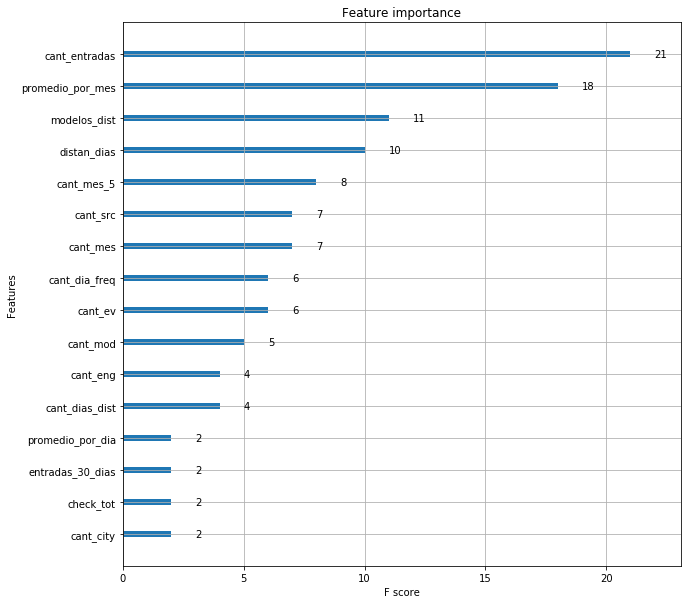

In [178]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

objective ='binary:hinge', 
                colsample_bytree = 0.8, learning_rate = 0.1,
                max_depth = 5, n_estimators = 6, eval_metric = "auc"

In [325]:
params = {"objective":"binary:hinge",'colsample_bytree': 0.8,
          'learning_rate': 0.1, 'max_depth': 5, "n_estimators" : 6}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=10,
                    num_boost_round=10,
                    metrics="auc", as_pandas=True, seed=123);

[23:31:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[23:31:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[23:31:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[23:31:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[23:31:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[23:31:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[23:31:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

In [329]:
#cv_results.sort_values("train-auc-mean", ascending=False)
cv_results

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.500000,0.000000,0.500000,0.000000
1,0.500000,0.000000,0.500000,0.000000
2,0.500000,0.000000,0.500000,0.000000
3,0.500000,0.000000,0.500000,0.000000
4,0.500000,0.000000,0.500000,0.000000
5,0.620688,0.022111,0.562280,0.038714
6,0.587415,0.018263,0.535153,0.024765
7,0.566936,0.016277,0.515376,0.017670
8,0.555486,0.014768,0.509091,0.009177
9,0.548208,0.013182,0.507178,0.009781


In [5]:
tf_test = pd.read_csv("trocafone_kaggle_test.csv")
tf_test.head()

,person
0,4886f805
1,0297fc1e
2,2d681dd8
3,cccea85e
4,4c8a8b93


## Cantidad de entradas desde campañas

In [203]:
df_events_campaign = df[['person','campaign_source']].dropna()


top_5_campanias = df_events_campaign['campaign_source'].value_counts().head(5).index
df_events_campaign = df_events_campaign.loc[df_events_campaign['campaign_source'].isin(top_5_campanias)]
df_events_campaign = pd.concat([df_events_campaign['person'],\
        pd.get_dummies(df_events_campaign['campaign_source'])],axis = 1).groupby('person').sum().reset_index()
df_events_campaign.head()

,person,criteo,emblue,google,rtbhouse,zanox
0,00091926,1.0,0.0,13.0,1.0,0.0
1,00091a7a,0.0,0.0,1.0,0.0,0.0
2,000ba417,0.0,0.0,1.0,0.0,0.0
3,000c79fe,0.0,0.0,1.0,0.0,0.0
4,000e4d9e,0.0,0.0,4.0,0.0,9.0


In [204]:
# Merge
labels_con_camps = pd.merge(df_events_campaign, labels_con_eventos, on="person", how="inner")
labels_con_camps_num = labels_con_camps.drop(columns="person")
labels_con_camps_num.head()


,criteo,emblue,google,rtbhouse,zanox,ad campaign hit,brand listing,search engine hit,searched products,promedio_por_mes,...,cant_eng,cant_mod,cant_ev,check_tot,cant_entradas,cant_mes_5,entradas_30_dias,cant_mes,cant_dia_freq,label
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,9.0,0.058824,...,1,4,9,1,17,17,16,17,17,0
1,5.0,0.0,17.0,7.0,0.0,29.0,165.0,13.0,11.0,0.008493,...,12,63,189,15,471,290,358,290,72,0
2,3.0,0.0,4.0,0.0,0.0,7.0,7.0,6.0,0.0,0.031250,...,6,20,52,1,96,54,64,54,17,0
3,2.0,0.0,10.0,0.0,0.0,13.0,4.0,10.0,0.0,0.055556,...,10,8,17,3,54,5,26,46,22,0
4,0.0,0.0,2.0,0.0,0.0,2.0,17.0,1.0,0.0,0.052632,...,1,3,17,1,38,26,25,26,26,0


### Prueba

In [205]:
# Separamos la variable a predecir

X, y = labels_con_camps_num.iloc[:,:-1], labels_con_camps_num.iloc[:,-1]

# Convertimos los datos a DMatrix

data_dmatrix = xgb.DMatrix(data=X,label=y, weight={1: 1, 0: 0.1})

#Creamos set de entrenamiento y test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [206]:
#Instanciamos el regresor de XGBoost

ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

xg_reg = xgb.XGBRegressor(objective ='binary:hinge', 
                colsample_bytree = 0.8, learning_rate = 0.1,
                max_depth = 5, n_estimators = 6, eval_metric = "auc", min_child_weight=1000)


In [207]:
#Entrenamos

xg_reg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eval_metric='auc', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=1000, missing=None,
       n_estimators=6, n_jobs=1, nthread=None, objective='binary:hinge',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [208]:
# Predecimos

preds = xg_reg.predict(X_test)

In [209]:
# Vemos 
train_accuracy = accuracy_score(y_train, xg_reg.predict(X_train))
test_accuracy = accuracy_score(y_test, preds)
matriz_de_confusion = confusion_matrix(y_test, preds)
area_debajo_de_curva = roc_auc_score(y_test, preds)

print("Train accuracy: ", train_accuracy)
print("Test acuracy: ", test_accuracy)
print("ROC auc score: ", area_debajo_de_curva)
print("Confusion matrix: ")
print(matriz_de_confusion)

Train accuracy:  0.8643130582730753
Test acuracy:  0.8520408163265306
ROC auc score:  0.5653311481410614
Confusion matrix: 
[[1485  208]
 [  53   18]]


## Promedio de entradas en dias de semana

## Expanding Mean hasta un ckeckout

In [330]:
df_checkouts = df[["timestamp", "person", "event"]]
df_checkouts["checkout"] = (df_checkouts["event"] == "checkout") * 1
df_checkouts.sort_values("timestamp", inplace=True)
df_checkouts.head()

C:\Users\seba\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\seba\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,timestamp,person,event,checkout
2307205,2018-01-01 08:09:31,0f4e2a4b,visited site,0
1753202,2018-01-01 08:09:31,0f4e2a4b,search engine hit,0
1753201,2018-01-01 08:09:31,0f4e2a4b,ad campaign hit,0
1753200,2018-01-01 08:09:44,0f4e2a4b,viewed product,0
1753207,2018-01-01 08:45:29,0f4e2a4b,ad campaign hit,0


In [354]:
cumsum = df_checkouts.groupby("person")["checkout"].cumsum() - df_checkouts["checkout"]
cumcnt = df_checkouts.groupby("person").cumcount()
df_checkouts['person_mean_target'] = cumsum/cumcnt
df_checkouts_coso = df_checkouts[["person","timestamp", "person_mean_target"]]
df_checkouts_coso = df_checkouts_coso.sort_values("timestamp", ascending=False)
df_checkouts_coso = df_checkouts_coso.drop_duplicates(subset=['person'])
df_checkouts_coso = df_checkouts_coso[["person", "person_mean_target"]]
df_checkouts_coso.head()

C:\Users\seba\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,person,person_mean_target
886415,d54e0bdb,0.018657
456686,2f0d27b2,0.000000
456450,1dae1e78,0.000000
434218,d2561d30,0.025641
1993919,8c27c9a2,0.018182


In [355]:
# Merge

df_con_coso = pd.merge(df_checkouts_coso,labels_con_promedios, on="person", how="inner")

df_con_coso_num = df_con_coso.drop(columns="person")

## Cantidad de visitas a productos Apple y Samsung

In [109]:
df_productos = df[["person", "event", "model"]]
df_productos = df_productos.loc[df_productos["event"] == "viewed product"]
df_productos = df_productos.loc[(df_productos["model"].str.contains("iPhone") )|( df_productos["model"].str.contains("Samsung") )]
df_productos.head()

df_apple = df_productos.loc[df_productos["model"].str.contains("iPhone")]
df_samsung = df_productos.loc[df_productos["model"].str.contains("Samsung")]                           

vistas_apple = df_apple["person"].value_counts().reset_index()
vistas_apple.columns = ["person", "vistas_apple"]

vistas_samsung = df_apple["person"].value_counts().reset_index()
vistas_samsung.columns = ["person", "vistas_samsung"]

vistas_prods = pd.merge(vistas_samsung, vistas_apple, on="person", how="inner")
vistas_prods.head()

,person,vistas_samsung,vistas_apple
0,6abd2bf1,2051,2051
1,b1f4dbf6,1866,1866
2,9bf968c5,1557,1557
3,bfb74b38,1526,1526
4,6f19cfd9,1442,1442


In [118]:
# Merge

df_con_vistas_prods = pd.merge(vistas_prods,labels_con_promedios, on="person", how="inner")

df_con_vistas_prods_num = df_con_vistas_prods.drop(columns="person")

### Prueba

In [356]:
# Separamos la variable a predecir

X, y = df_con_coso_num.iloc[:,:-1], df_con_coso_num.iloc[:,-1]

# Convertimos los datos a DMatrix

data_dmatrix = xgb.DMatrix(data=X,label=y)

#Creamos set de entrenamiento y test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [357]:
#Instanciamos el regresor de XGBoost

ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

xg_reg = xgb.XGBRegressor(objective ='binary:hinge', 
                colsample_bytree = 0.8, learning_rate = 0.1,
                max_depth = 5, n_estimators = 6)


In [358]:
#Entrenamos

xg_reg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=6,
       n_jobs=1, nthread=None, objective='binary:hinge', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [359]:
# Predecimos

preds = xg_reg.predict(X_test)

In [360]:
# Vemos 
train_accuracy = accuracy_score(y_train, xg_reg.predict(X_train))
test_accuracy = accuracy_score(y_test, preds)
matriz_de_confusion = confusion_matrix(y_test, preds)
area_debajo_de_curva = roc_auc_score(y_test, preds)

print("Train accuracy: ", train_accuracy)
print("Test acuracy: ", test_accuracy)
print("ROC auc score: ", area_debajo_de_curva)
print("Confusion matrix: ")
print(matriz_de_confusion)

Train accuracy:  0.9453834334404246
Test acuracy:  0.9324022346368716
ROC auc score:  0.5664733017066916
Confusion matrix: 
[[1657   62]
 [  59   12]]


## Cantidad de busquedas en 'searched products' y 'search engine hit'

In [91]:
df_search = df.loc[(df["event"] == "searched products" )| (df["event"] == "search engine hit" )]

searched_products = df_search.loc[df_search["event"] == "searched products"]
cant_searched_products = searched_products["person"].value_counts().reset_index()
cant_searched_products.columns = ["person", "cant_search_prod"]

engine_hit = df_search.loc[df_search["event"] == "search engine hit"]
cant_engine_hit = engine_hit["person"].value_counts().reset_index()
cant_engine_hit.columns = ["person", "cant_engine_hit"]

cant_busquedas = pd.merge(cant_engine_hit, cant_searched_products, on="person", how="inner")


In [92]:
# Merge

labels_con_busq = pd.merge(cant_busquedas, labels_con_promedios, on="person", how="inner")
labels_con_busq_num = labels_con_busq.drop(columns="person")
labels_con_busq_num.head()

,cant_engine_hit,cant_search_prod,promedio_por_mes,promedio_por_dia,cant_dias_dist,modelos_dist,distan_dias,cant_city,cant_src,cant_eng,cant_mod,cant_ev,check_tot,cant_entradas,cant_mes_5,entradas_30_dias,cant_mes,cant_dia_freq,label
0,245,3,0.002493,0.030907,62,58,120,105,335,245,170,744,47,2006,388,378,861,198,0
1,136,739,0.000622,0.017402,28,66,29,66,152,136,61,739,10,1609,1609,1608,1609,191,0
2,130,214,0.002339,0.037427,32,24,41,63,8,130,87,214,4,855,760,759,760,138,0
3,102,2,0.003902,0.056585,58,46,98,72,128,102,130,450,2,1025,103,105,585,102,0
4,93,121,0.001883,0.031387,50,27,77,92,78,93,416,692,17,1593,412,420,956,216,0


### Prueba

In [98]:
# Separamos la variable a predecir

X, y = labels_con_busq_num.iloc[:,:-1], labels_con_busq_num.iloc[:,-1]

# Convertimos los datos a DMatrix

data_dmatrix = xgb.DMatrix(data=X,label=y)

#Creamos set de entrenamiento y test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [99]:
#Instanciamos el regresor de XGBoost

ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

xg_reg = xgb.XGBRegressor(objective ='binary:hinge', 
                colsample_bytree = 0.8, learning_rate = 0.1,
                max_depth = 5, n_estimators = 6, scale_pos_weight = 100, min_child_weight=1000)


In [100]:
#Entrenamos

xg_reg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1000, missing=None, n_estimators=6,
       n_jobs=1, nthread=None, objective='binary:hinge', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=100, seed=None,
       silent=True, subsample=1)

In [101]:
# Predecimos

preds = xg_reg.predict(X_test)

In [102]:
# Vemos 
train_accuracy = accuracy_score(y_train, xg_reg.predict(X_train))
test_accuracy = accuracy_score(y_test, preds)
matriz_de_confusion = confusion_matrix(y_test, preds)
area_debajo_de_curva = roc_auc_score(y_test, preds)

print("Train accuracy: ", train_accuracy)
print("Test acuracy: ", test_accuracy)
print("ROC auc score: ", area_debajo_de_curva)
print("Confusion matrix: ")
print(matriz_de_confusion)

Train accuracy:  0.6928886091881686
Test acuracy:  0.6779874213836478
ROC auc score:  0.5270641194554239
Confusion matrix: 
[[526 233]
 [ 23  13]]
